In [11]:
# 📦 Step 1: Import Libraries
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from einops import rearrange
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using:", device)

Using: cpu


In [3]:
# 📂 Step 2: Load Preprocessed Data
df = pd.read_csv("../data/processed/etth1_processed.csv", parse_dates=["date"], index_col="date")
target = df["OT"].values

In [4]:
# 🧩 Step 3: Create Dataset
class TimeSeriesDataset(Dataset):
    def __init__(self, series, window_size):
        self.series = torch.tensor(series, dtype=torch.float32)
        self.window_size = window_size

    def __len__(self):
        return len(self.series) - self.window_size

    def __getitem__(self, idx):
        x = self.series[idx:idx+self.window_size]
        y = self.series[idx+self.window_size]
        return x.unsqueeze(1), y

In [5]:
# 🔄 Step 4: Dataloader
window_size = 96
batch_size = 32
dataset = TimeSeriesDataset(target, window_size)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [6]:
# 🧠 Step 5: Simplified Informer Model
class ProbSparseSelfAttention(nn.Module):
    """Approximate attention mechanism (ProbSparse Attention)"""
    def __init__(self, d_model):
        super().__init__()
        self.scale = d_model ** -0.5

    def forward(self, Q, K, V):
        scores = torch.matmul(Q, K.transpose(-2, -1)) * self.scale
        attn = torch.softmax(scores, dim=-1)
        output = torch.matmul(attn, V)
        return output

class InformerBlock(nn.Module):
    def __init__(self, d_model, n_heads):
        super().__init__()
        self.qkv_proj = nn.Linear(d_model, d_model * 3)
        self.attention = ProbSparseSelfAttention(d_model)
        self.out_proj = nn.Linear(d_model, d_model)
        self.norm = nn.LayerNorm(d_model)

    def forward(self, x):
        qkv = self.qkv_proj(x)
        q, k, v = rearrange(qkv, 'b t (three h) -> three b t h', three=3)
        out = self.attention(q, k, v)
        out = self.out_proj(out)
        return self.norm(out + x)

class InformerForecast(nn.Module):
    def __init__(self, input_size=1, d_model=64, n_heads=4, num_layers=2):
        super().__init__()
        self.embedding = nn.Linear(input_size, d_model)
        self.encoder = nn.ModuleList([
            InformerBlock(d_model, n_heads) for _ in range(num_layers)
        ])
        self.output_layer = nn.Linear(d_model, 1)

    def forward(self, x):
        x = self.embedding(x)
        for layer in self.encoder:
            x = layer(x)
        return self.output_layer(x[:, -1, :])  # predict based on last token

In [8]:
# ⚙️ Step 6: Train the Informer Model
model = InformerForecast().to(device)
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

epochs = 10
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for x, y in dataloader:
        x, y = x.to(device), y.to(device).unsqueeze(1)
        pred = model(x)
        loss = loss_fn(pred, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1} | Loss: {total_loss / len(dataloader):.4f}")

# Save the trained model
torch.save(model.state_dict(), '../models/checkpoints/informer_transformer_model.pth')

Epoch 1 | Loss: 0.0122
Epoch 2 | Loss: 0.0005
Epoch 3 | Loss: 0.0004
Epoch 4 | Loss: 0.0004
Epoch 5 | Loss: 0.0004
Epoch 6 | Loss: 0.0004
Epoch 7 | Loss: 0.0005
Epoch 8 | Loss: 0.0005
Epoch 9 | Loss: 0.0005
Epoch 10 | Loss: 0.0005


In [ ]:
# Evaluation
model.eval()
predictions = []
true_values = []
with torch.no_grad():
    for x, y in dataloader:
        x, y = x.to(device), y.to(device).unsqueeze(1)
        pred = model(x)
        predictions.append(pred.cpu().numpy())
        true_values.append(y.cpu().numpy())

predictions = np.concatenate(predictions, axis=0)
true_values = np.concatenate(true_values, axis=0)

# Inverse transform predictions and true values
# Add dummy columns to match the scaler's expected input shape
dummy_shape = (predictions.shape[0], df.shape[1])  # Match the number of columns in the original data
predictions_full = np.zeros(dummy_shape)
true_values_full = np.zeros(dummy_shape)

# Fill the relevant column (e.g., 'OT') with predictions and true values
predictions_full[:, -1] = predictions.flatten()
true_values_full[:, -1] = true_values.flatten()

# Apply inverse transform
scaler = MinMaxScaler()
scaler.fit(df)  # Fit scaler on the original dataframe
predictions = scaler.inverse_transform(predictions_full)[:, -1]  # Extract the 'OT' column
true_values = scaler.inverse_transform(true_values_full)[:, -1]  # Extract the 'OT' column

MSE: 0.0004, MAE: 0.0138


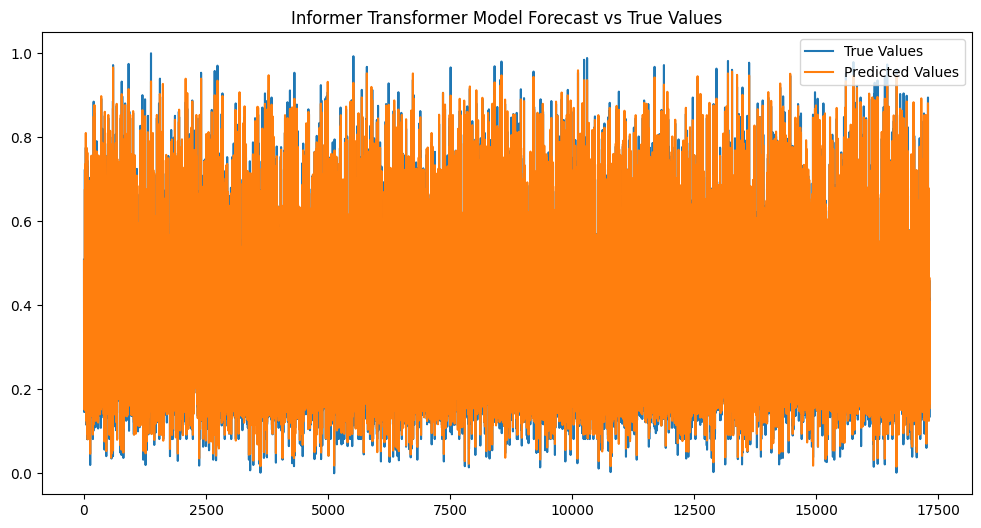

Results saved to ../models/metrics/informer_metrics.csv


<Figure size 640x480 with 0 Axes>

In [16]:
#calculate metrics 
mse=mean_squared_error(true_values, predictions)
mae=mean_absolute_error(true_values, predictions)
print(f"MSE: {mse:.4f}, MAE: {mae:.4f}")

# Plot the results for comparison
plt.figure(figsize=(12, 6))
plt.plot(true_values, label="True Values")
plt.plot(predictions, label="Predicted Values")
plt.legend()
plt.title("Informer Transformer Model Forecast vs True Values")
plt.show()

# Save the results for comparison
results = pd.DataFrame({
    "True Values": true_values.flatten(),
    "Predictions": predictions.flatten()
})

results.to_csv("../models/metrics/informer_metrics.csv", index=False)
print("Results saved to ../models/metrics/informer_metrics.csv")

#save as png
plt.savefig("../models/metrics/informer_metrics.png")
print("Plot saved to ../models/metrics/informer_metrics.png")